In [1]:
## PREPARAÇÃO DOS DADOS

# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import warnings
import os
warnings.filterwarnings('ignore')

# Configuração para melhor visualização
sns.set_theme()
pd.set_option('display.max_columns', None)

In [2]:
# Carregar o arquivo Excel


file_path = "C:/Users/Flavia Gerhardt/source/repos/pb_validacao_modelo_classificacao_fg/pb_validacao_modelo_classificacao_fg/data/Mall_Customers.csv"


df = pd.read_csv(file_path)

# Análise inicial

# Exibir as primeiras linhas do DataFrame
print("Primeiras linhas da base de dados:")
print(df.head())

# Informações gerais do DataFrame
print("\nInformações gerais do dataset:")
print(df.info())

# Estatísticas descritivas das variáveis
print("\nEstatísticas descritivas:")
print(df.describe())


Primeiras linhas da base de dados:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usag

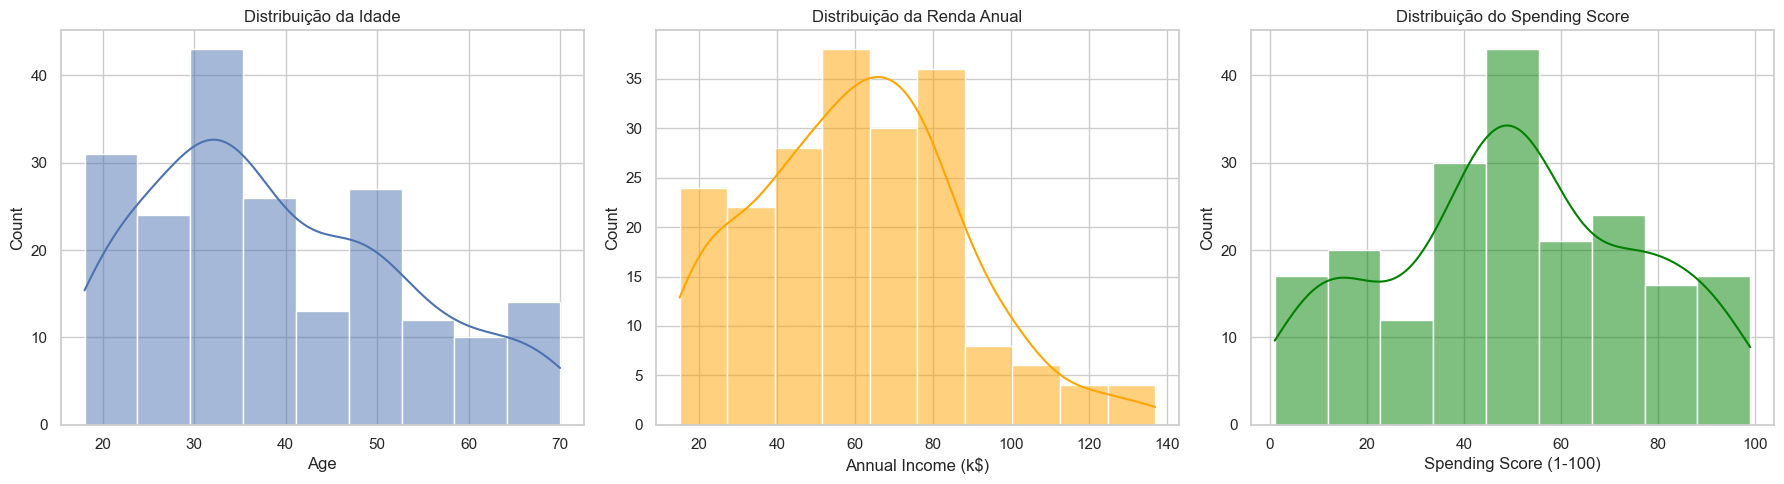

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar uma pasta para salvar os gráficos, caso não exista
os.makedirs("graficos", exist_ok=True)

# Visualização da Faixa Dinâmica das Variáveis: 
# Gerar gráficos para analisar a distribuição e a faixa dinâmica das variáveis Age, Annual Income (k$) e Spending Score (1-100)

# Configurar estilo
sns.set(style="whitegrid")

# Gráficos de distribuição
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Idade
sns.histplot(df['Age'], kde=True, ax=axes[0])
axes[0].set_title('Distribuição da Idade')

# Renda Anual
sns.histplot(df['Annual Income (k$)'], kde=True, ax=axes[1], color="orange")
axes[1].set_title('Distribuição da Renda Anual')

# Spending Score
sns.histplot(df['Spending Score (1-100)'], kde=True, ax=axes[2], color="green")
axes[2].set_title('Distribuição do Spending Score')

plt.tight_layout()
plt.savefig("graficos/Faixa Dinâmica das Variáveis.png")
plt.show()


In [4]:
## Pré processamento

# Remover coluna CustomerID
df_clean = df.drop(columns=['CustomerID'])
X_scaled = df.drop(columns=['CustomerID'])

# Aplicar one-hot encoding em Gender (opcional para futuras análises)
df_clean = pd.get_dummies(df_clean, columns=['Gender'], drop_first=True)
X_scaled = pd.get_dummies(X_scaled, columns=['Gender'], drop_first=True)

# Normalizar as variáveis numéricas
scaler_m = MinMaxScaler()
scaler_s = StandardScaler()
columns_to_scale = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df_clean[columns_to_scale] = scaler_m.fit_transform(df_clean[columns_to_scale])
X_scaled[columns_to_scale] = scaler_s.fit_transform(X_scaled[columns_to_scale])

# Exibir os dados pré-processados
X_scaled.head()



,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,True
1,-1.281035,-1.738999,1.195704,True
2,-1.352802,-1.700830,-1.715913,False
3,-1.137502,-1.700830,1.040418,False
4,-0.563369,-1.662660,-0.395980,False


In [5]:
df_clean.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,0.019231,0.000000,0.387755,True
1,0.057692,0.000000,0.816327,True
2,0.038462,0.008197,0.051020,False
3,0.096154,0.008197,0.775510,False
4,0.250000,0.016393,0.397959,False


Analisando os dois resultados mostrados:
O primeiro conjunto de dados mostra valores normalizados usando StandardScaler, que centraliza os dados ao redor de 0 e escala pela variância, resultando em valores negativos e positivos.
O segundo conjunto de dados mostra valores normalizados usando MinMaxScaler, que escala os dados para o intervalo [0,1], o que geralmente é mais adequado para algoritmos de clusterização.
O segundo resultado (MinMaxScaler) é melhor por algumas razões:

Interpretabilidade: Os valores entre 0 e 1 são mais fáceis de interpretar
Adequação para clusterização: Algoritmos como K-Means e DBScan funcionam melhor com valores positivos e em escalas similares
Preservação de zeros: O MinMaxScaler preserva o zero como um valor significativo, o que pode ser importante para a análise
Consistência: Todos os valores estão na mesma escala positiva, facilitando a comparação entre as diferentes características

Portanto, recomendo continuar a análise usando os dados normalizados com MinMaxScaler (segundo resultado), pois proporcionará resultados mais robustos e interpretáveis na clusterização.

Text(0.5, 1.0, 'Matriz de Correlação das Variáveis')

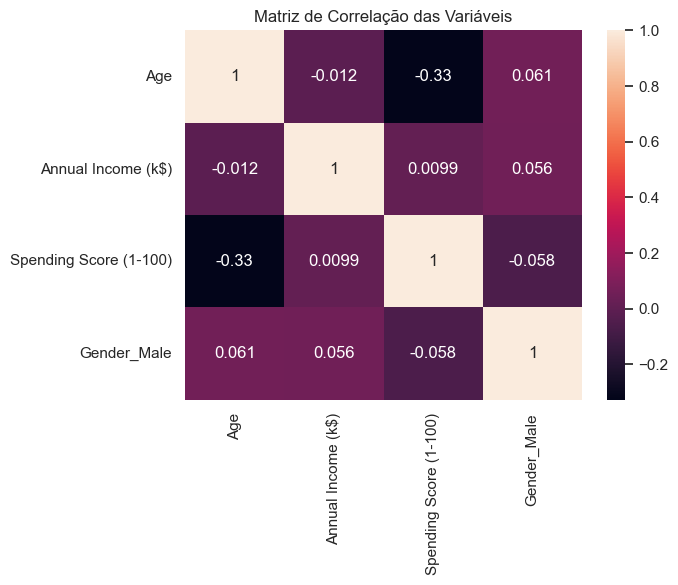

In [6]:
# Adicionar análise de correlação
correlation_matrix = df_clean.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Matriz de Correlação das Variáveis')

In [7]:
from scipy.stats import spearmanr
corr, _ = spearmanr(df_clean['Age'], df_clean['Spending Score (1-100)'])
print(f'Correlação de Spearman: {corr}')

Correlação de Spearman: -0.3449397740165373


<Axes: xlabel='Age', ylabel='Spending Score (1-100)'>

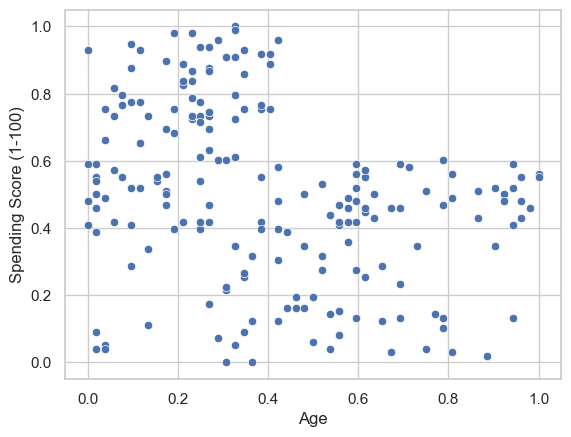

In [8]:
import seaborn as sns
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df_clean)



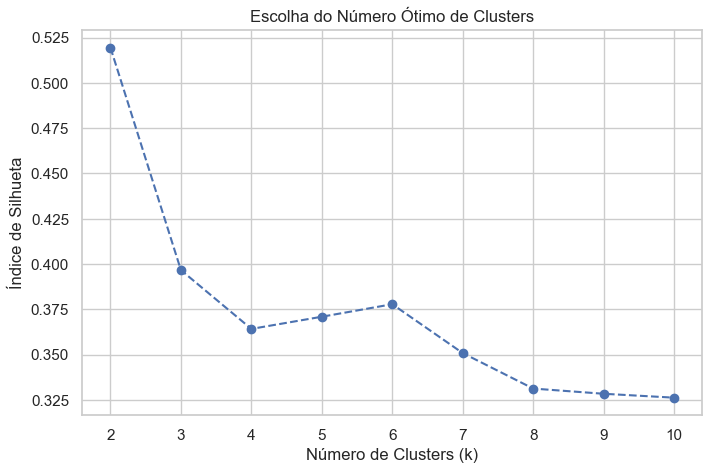

2

In [9]:
# método do índice de silhueta para determinar o número ideal de clusters (k) para um algoritmo K-Means

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determinar o número ideal de clusters usando o índice de silhueta
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_clean)
    score = silhouette_score(df_clean, cluster_labels)
    silhouette_scores.append(score)

# Gráfico do índice de silhueta
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Índice de Silhueta')
plt.title('Escolha do Número Ótimo de Clusters')
plt.savefig("graficos/Gráfico do índice de silhueta.png")
plt.show()

# Melhor valor de k
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
best_k


Iniciando análise de clusters com validação cruzada...

Plotando análise de estabilidade dos clusters...


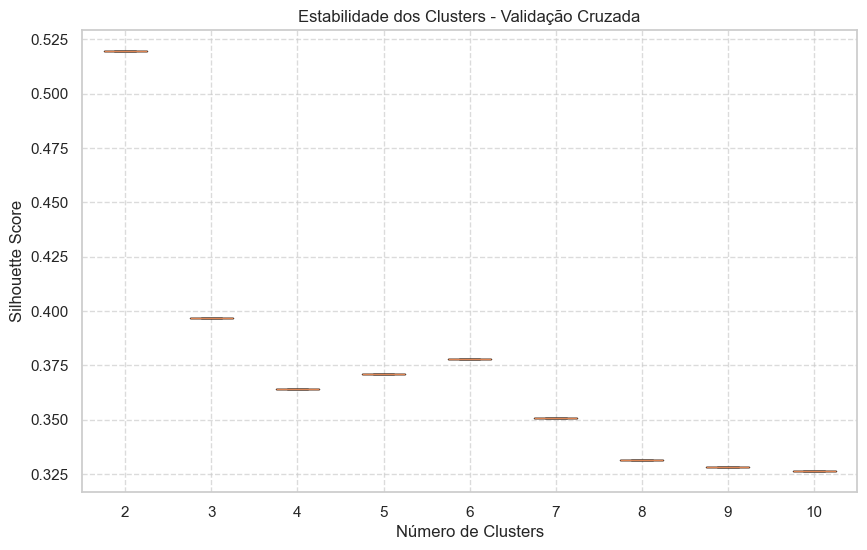


Melhor número de clusters (baseado na média da validação cruzada): 2

Gerando perfil de silhueta detalhado para o melhor número de clusters...


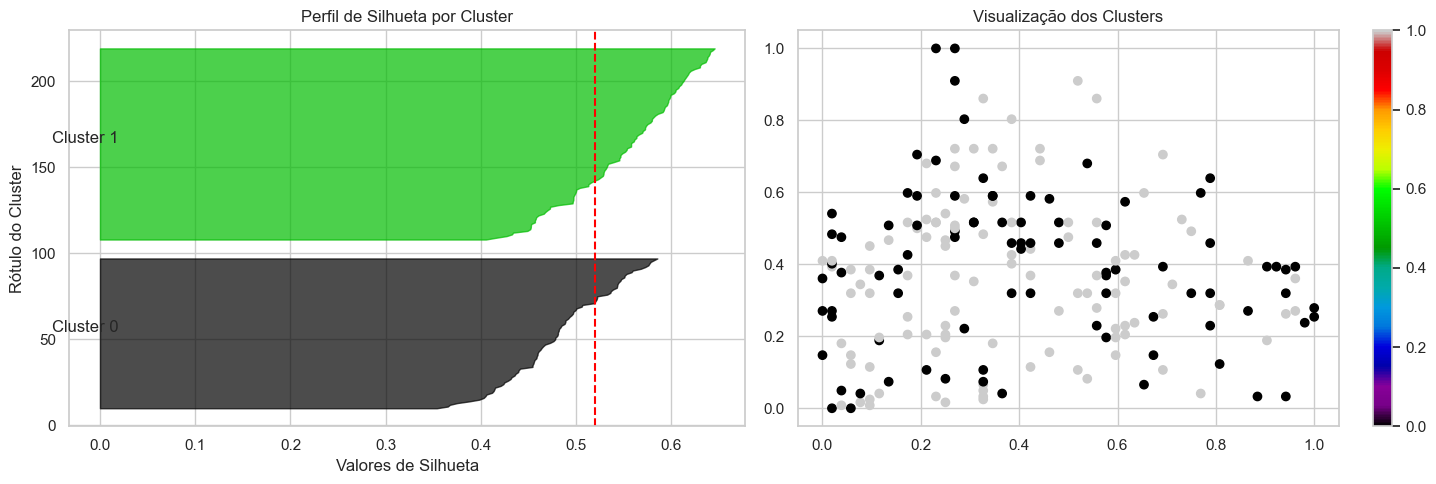


Estatísticas de estabilidade para cada número de clusters:

K = 2
Média do Silhouette Score: 0.519
Desvio Padrão: 0.000
Coeficiente de Variação: 0.000

K = 3
Média do Silhouette Score: 0.397
Desvio Padrão: 0.000
Coeficiente de Variação: 0.000

K = 4
Média do Silhouette Score: 0.364
Desvio Padrão: 0.000
Coeficiente de Variação: 0.000

K = 5
Média do Silhouette Score: 0.371
Desvio Padrão: 0.000
Coeficiente de Variação: 0.000

K = 6
Média do Silhouette Score: 0.378
Desvio Padrão: 0.000
Coeficiente de Variação: 0.000

K = 7
Média do Silhouette Score: 0.351
Desvio Padrão: 0.000
Coeficiente de Variação: 0.000

K = 8
Média do Silhouette Score: 0.331
Desvio Padrão: 0.000
Coeficiente de Variação: 0.000

K = 9
Média do Silhouette Score: 0.328
Desvio Padrão: 0.000
Coeficiente de Variação: 0.000

K = 10
Média do Silhouette Score: 0.326
Desvio Padrão: 0.000
Coeficiente de Variação: 0.000


In [10]:
## Validação Cruzada com Silhouette Score


import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def cross_validated_silhouette(data, max_clusters=10, n_splits=5):
    """
    Realiza validação cruzada para avaliar a estabilidade dos clusters
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_silhouette_scores = defaultdict(list)
    
    for k in range(2, max_clusters + 1):
        for train_idx, val_idx in kf.split(data):
            kmeans = KMeans(n_clusters=k, random_state=42)
            cluster_labels = kmeans.fit_predict(data)
            score = silhouette_score(data, cluster_labels)
            cv_silhouette_scores[k].append(score)
    
    return cv_silhouette_scores

def plot_silhouette_analysis(data, k):
    """
    Visualiza o perfil de silhueta para cada cluster
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Aplica K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    
    # Calcula silhueta para cada amostra
    silhouette_vals = silhouette_samples(data, cluster_labels)
    
    # Plot da silhueta
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_vals.sort()
        
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
        y_lower = y_upper + 10
    
    ax1.set_title('Perfil de Silhueta por Cluster')
    ax1.set_xlabel('Valores de Silhueta')
    ax1.set_ylabel('Rótulo do Cluster')
    ax1.axvline(x=silhouette_score(data, cluster_labels), color="red", linestyle="--")
    
    # Visualização dos clusters
    if data.shape[1] > 2:
        # Se tivermos mais de 2 dimensões, usamos as duas primeiras features
        scatter = ax2.scatter(data.iloc[:, 0], data.iloc[:, 1], 
                            c=cluster_labels, cmap='nipy_spectral')
    else:
        scatter = ax2.scatter(data[:, 0], data[:, 1], 
                            c=cluster_labels, cmap='nipy_spectral')
    
    ax2.set_title('Visualização dos Clusters')
    plt.colorbar(scatter, ax=ax2)
    plt.tight_layout()
    plt.savefig("graficos/Gráfico Visualização dos clusters.png")
    plt.show()

def plot_cluster_stability(cv_scores):
    """
    Visualiza a estabilidade dos clusters através das iterações da validação cruzada
    """
    plt.figure(figsize=(10, 6))
    
    # Preparar dados para o box plot
    data_to_plot = [scores for k, scores in sorted(cv_scores.items())]
    
    # Criar box plot
    plt.boxplot(data_to_plot, labels=range(2, len(cv_scores) + 2))
    
    plt.title('Estabilidade dos Clusters - Validação Cruzada')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("graficos/Gráfico Visualização box plot.png")
    plt.show()

# Executar análise
print("Iniciando análise de clusters com validação cruzada...")
cv_scores = cross_validated_silhouette(df_clean)

# Plotar estabilidade dos clusters
print("\nPlotando análise de estabilidade dos clusters...")
plot_cluster_stability(cv_scores)

# Encontrar o melhor número de clusters baseado na média dos scores
mean_scores = {k: np.mean(scores) for k, scores in cv_scores.items()}
best_k = max(mean_scores.items(), key=lambda x: x[1])[0]
print(f"\nMelhor número de clusters (baseado na média da validação cruzada): {best_k}")

# Plotar análise detalhada de silhueta para o melhor k
print("\nGerando perfil de silhueta detalhado para o melhor número de clusters...")
plot_silhouette_analysis(df_clean, best_k)

# Calcular estatísticas de estabilidade
print("\nEstatísticas de estabilidade para cada número de clusters:")
for k, scores in sorted(cv_scores.items()):
    print(f"\nK = {k}")
    print(f"Média do Silhouette Score: {np.mean(scores):.3f}")
    print(f"Desvio Padrão: {np.std(scores):.3f}")
    print(f"Coeficiente de Variação: {np.std(scores)/np.mean(scores):.3f}")

Analisando diferentes números de clusters...

Gerando gráficos de análise...


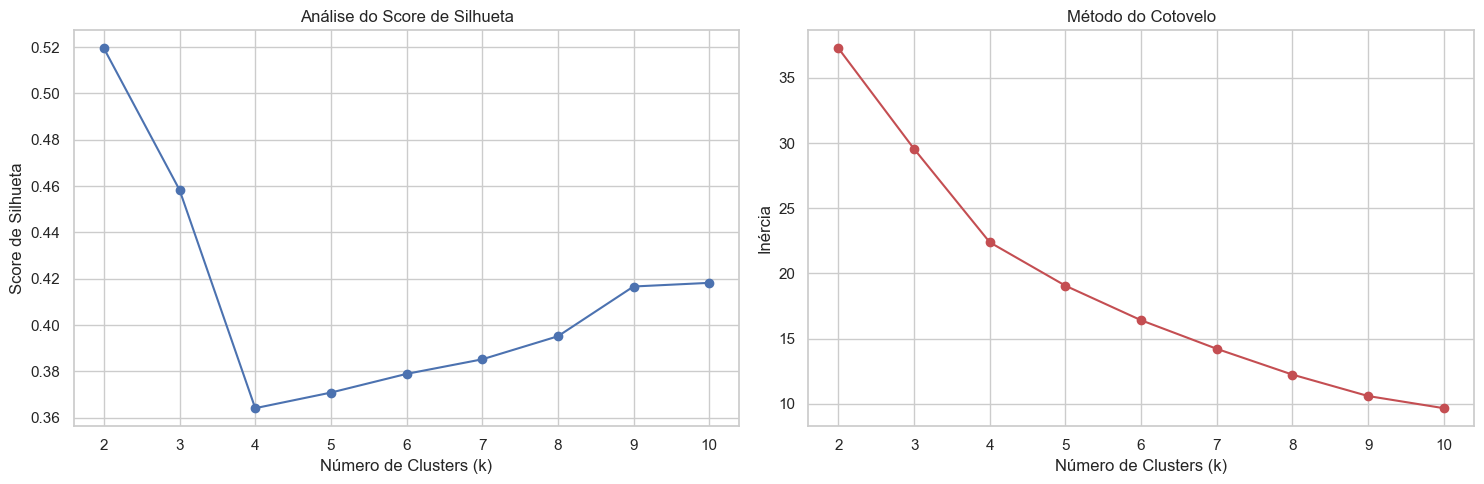


Melhor número de clusters (k) baseado no score de silhueta: 2
Score de silhueta para k=2: 0.519

Gerando perfil de silhueta para o melhor k...


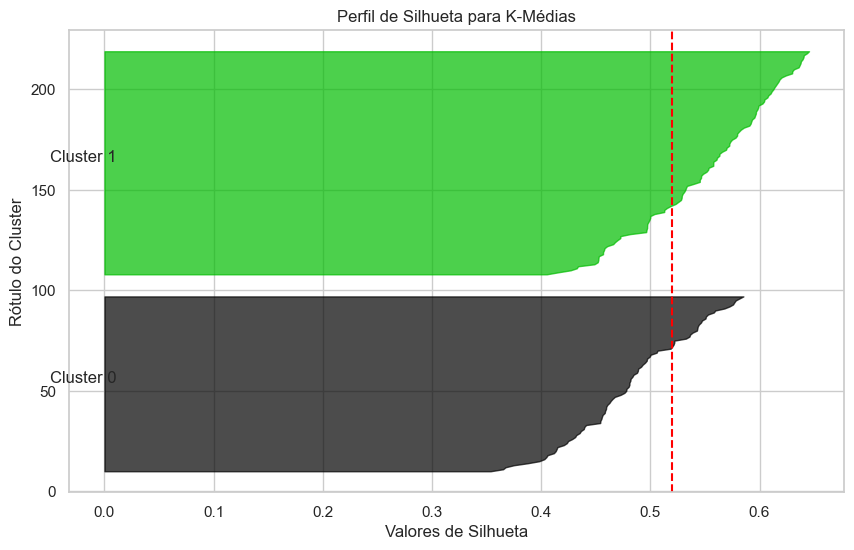


Estatísticas dos clusters:

Cluster 0 (Tamanho: 88)
          Age  Annual Income (k$)  Spending Score (1-100)  Cluster
count  88.000              88.000                  88.000     88.0
mean    0.419               0.387                   0.485      0.0
std     0.298               0.218                   0.285      0.0
min     0.000               0.000                   0.000      0.0
25%     0.188               0.250                   0.240      0.0
50%     0.365               0.389                   0.500      0.0
75%     0.625               0.516                   0.704      0.0
max     1.000               1.000                   0.980      0.0

Cluster 1 (Tamanho: 112)
           Age  Annual Income (k$)  Spending Score (1-100)  Cluster
count  112.000             112.000                 112.000    112.0
mean     0.387               0.363                   0.516      1.0
std      0.243               0.213                   0.246      0.0
min      0.000               0.008            

In [11]:
## processo completo de análise e visualização de clusters usando o algoritmo K-Means

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_kmeans_silhouette(data, max_k=10):
    """
    Analisa diferentes números de clusters usando K-Médias e índice de silhueta
    """
    # Armazenar scores de silhueta
    silhouette_scores = []
    inertias = []
    
    # Testar diferentes números de clusters
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        
        silhouette_scores.append(silhouette_score(data, labels))
        inertias.append(kmeans.inertia_)
    
    return silhouette_scores, inertias

def plot_kmeans_analysis(silhouette_scores, inertias):
    """
    Plota os resultados da análise
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot do Score de Silhueta
    k_range = range(2, len(silhouette_scores) + 2)
    ax1.plot(k_range, silhouette_scores, 'bo-')
    ax1.set_xlabel('Número de Clusters (k)')
    ax1.set_ylabel('Score de Silhueta')
    ax1.set_title('Análise do Score de Silhueta')
    ax1.grid(True)
    
    # Plot do Método do Cotovelo
    ax2.plot(k_range, inertias, 'ro-')
    ax2.set_xlabel('Número de Clusters (k)')
    ax2.set_ylabel('Inércia')
    ax2.set_title('Método do Cotovelo')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig("graficos/Gráfico do Score de Silhueta.png")
    plt.show()

def plot_silhouette_profile(data, best_k):
    """
    Plota o perfil de silhueta para o melhor k
    """
    # Criar o modelo com o melhor k
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    
    # Calcular silhueta para cada amostra
    silhouette_vals = silhouette_samples(data, cluster_labels)
    
    # Criar plot
    plt.figure(figsize=(10, 6))
    y_lower = 10
    
    # Plotar silhueta para cada cluster
    for i in range(best_k):
        ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_vals.sort()
        
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / best_k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
        y_lower = y_upper + 10
    
    plt.title('Perfil de Silhueta para K-Médias')
    plt.xlabel('Valores de Silhueta')
    plt.ylabel('Rótulo do Cluster')
    plt.axvline(x=silhouette_score(data, cluster_labels), color="red", linestyle="--")
    plt.savefig("graficos/Gráfico do índice de silhueta para cada cluster.png")
    plt.show()
    
    return cluster_labels

# Executar análise
print("Analisando diferentes números de clusters...")
silhouette_scores, inertias = analyze_kmeans_silhouette(df_clean)

# Plotar resultados
print("\nGerando gráficos de análise...")
plot_kmeans_analysis(silhouette_scores, inertias)

# Encontrar o melhor k baseado no score de silhueta
best_k = np.argmax(silhouette_scores) + 2
print(f"\nMelhor número de clusters (k) baseado no score de silhueta: {best_k}")
print(f"Score de silhueta para k={best_k}: {silhouette_scores[best_k-2]:.3f}")

# Plotar perfil de silhueta para o melhor k
print("\nGerando perfil de silhueta para o melhor k...")
final_labels = plot_silhouette_profile(df_clean, best_k)

# Análise dos clusters finais
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(df_clean)

# Adicionar labels ao DataFrame original
df_with_clusters = df_clean.copy()
df_with_clusters['Cluster'] = final_labels

# Estatísticas descritivas por cluster
print("\nEstatísticas dos clusters:")
for i in range(best_k):
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == i]
    print(f"\nCluster {i} (Tamanho: {len(cluster_data)})")
    print(cluster_data.describe().round(3))

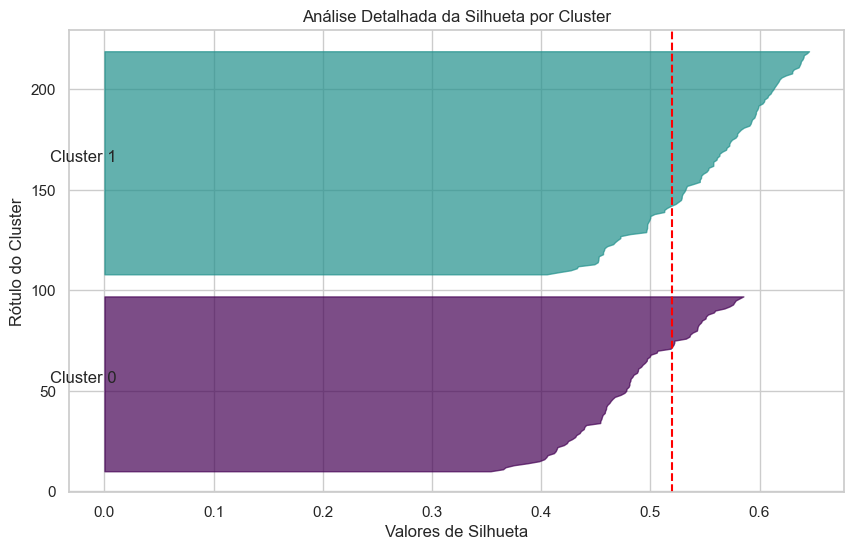

Índice de silhueta médio: 0.519

Cluster 0:
Tamanho do cluster: 88
Índice de silhueta médio: 0.481
Índice de silhueta mín: 0.354
Índice de silhueta máx: 0.585

Cluster 1:
Tamanho do cluster: 112
Índice de silhueta médio: 0.549
Índice de silhueta mín: 0.405
Índice de silhueta máx: 0.645

Centroides dos clusters:
Centroide 0: [39.80681818 62.22727273 48.51136364  1.        ]
Centroide 1: [3.80982143e+01 5.92500000e+01 5.15267857e+01 4.44089210e-16]


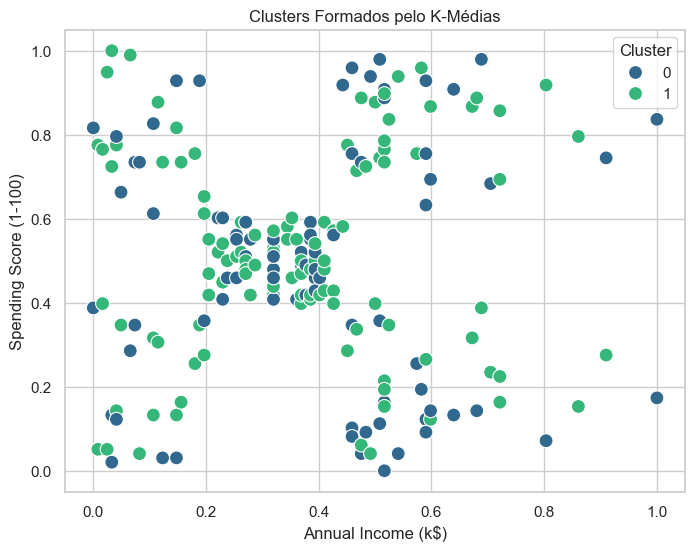

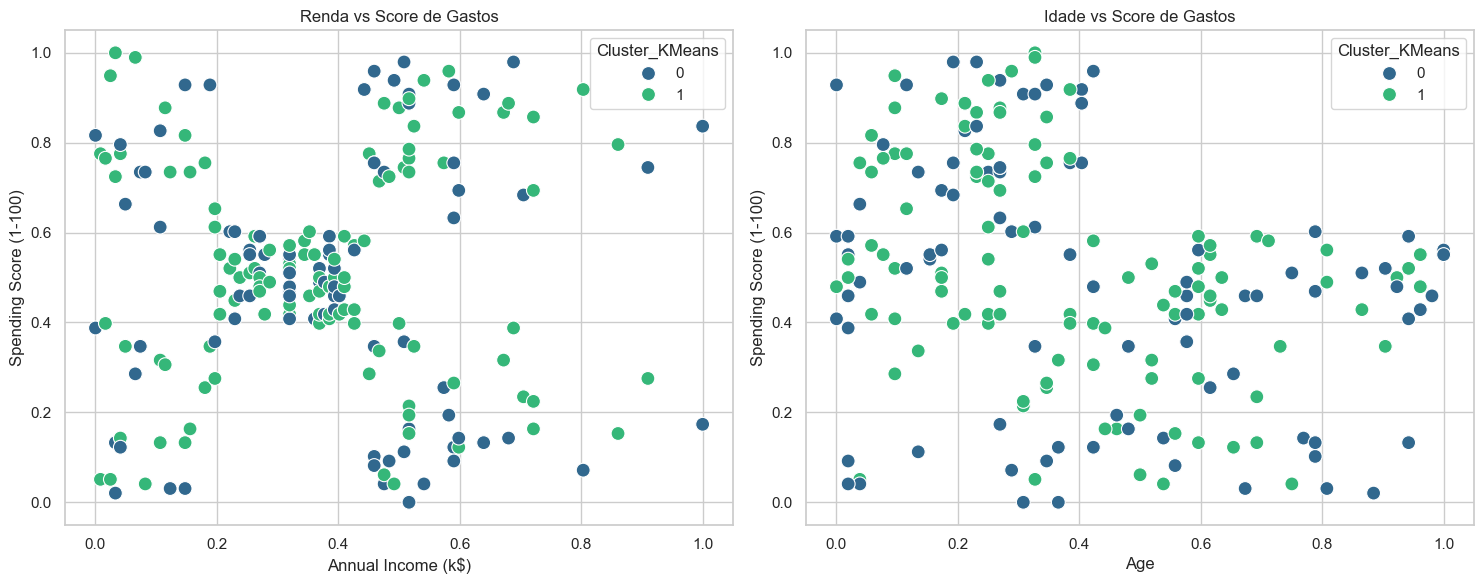

In [12]:
# Validação do k-means anterior e analise detalhada dos clusters formados.

# Carregar e preparar os dados

df_clean_validacao = df.copy()
df_clean_validacao['Gender_Male'] = (df_clean_validacao['Gender'] == 'Male')
df_clean_validacao = df_clean_validacao.drop(['CustomerID', 'Gender'], axis=1)

# Normalizar os dados
scaler = MinMaxScaler()
df_clean_scaled = pd.DataFrame(scaler.fit_transform(df_clean_validacao), columns=df_clean_validacao.columns)

# Aplicar K-Médias com k=2
best_k = 2
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_clean['Cluster_KMeans'] = kmeans.fit_predict(df_clean_scaled)

# Calcular silhueta
silhouette_vals = silhouette_samples(df_clean_scaled, kmeans.labels_)
silhouette_avg = silhouette_score(df_clean_scaled, kmeans.labels_)

# Análise detalhada da silhueta por cluster
plt.figure(figsize=(10, 6))
y_lower = 10

for i in range(best_k):
    cluster_silhouette_vals = silhouette_vals[kmeans.labels_ == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = len(cluster_silhouette_vals)
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(i / best_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color,
                      alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title('Análise Detalhada da Silhueta por Cluster')
plt.xlabel('Valores de Silhueta')
plt.ylabel('Rótulo do Cluster')
plt.savefig("graficos/Análise Detalhada da Silhueta.png")
plt.show()

# Imprimir métricas de silhueta
print(f"Índice de silhueta médio: {silhouette_avg:.3f}\n")
for i in range(best_k):
    cluster_silhouette = silhouette_vals[kmeans.labels_ == i]
    print(f"Cluster {i}:")
    print(f"Tamanho do cluster: {len(cluster_silhouette)}")
    print(f"Índice de silhueta médio: {np.mean(cluster_silhouette):.3f}")
    print(f"Índice de silhueta mín: {np.min(cluster_silhouette):.3f}")
    print(f"Índice de silhueta máx: {np.max(cluster_silhouette):.3f}\n")

# Análise dos centroides
print("Centroides dos clusters:")
centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)
for i, centroid in enumerate(centroids_original):
    print(f"Centroide {i}:", centroid)

# Visualização dos clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster_KMeans', palette='viridis', data=df_clean, s=100)
plt.title('Clusters Formados pelo K-Médias')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.savefig("graficos/Clusters Formados pelo K-Médias.png")
plt.show()

# Visualização de todas as dimensões
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Renda vs Score de Gastos
sns.scatterplot(ax=axes[0], x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster_KMeans', palette='viridis', data=df_clean, s=100)
axes[0].set_title('Renda vs Score de Gastos')

# Plot 2: Idade vs Score de Gastos
sns.scatterplot(ax=axes[1], x='Age', y='Spending Score (1-100)', 
                hue='Cluster_KMeans', palette='viridis', data=df_clean, s=100)
axes[1].set_title('Idade vs Score de Gastos')

plt.tight_layout()
plt.savefig("graficos/Visualização Múltipla dos Clusters.png")
plt.show()

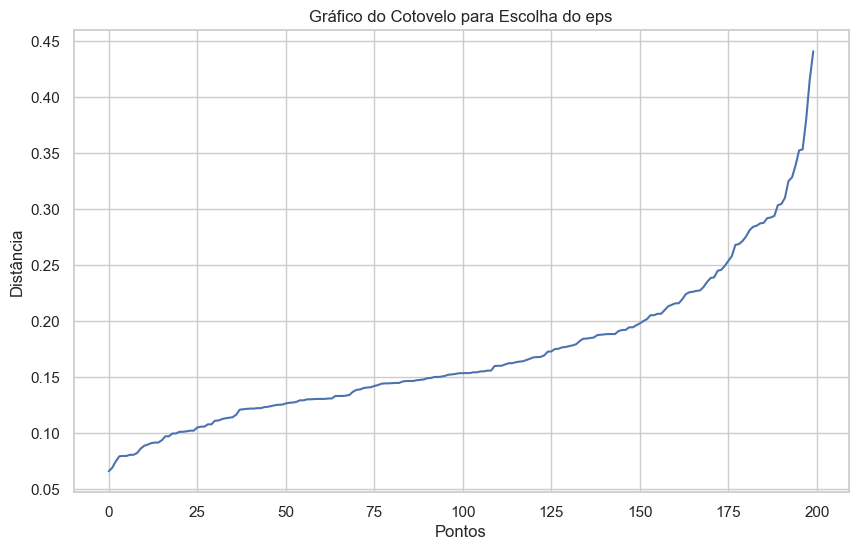

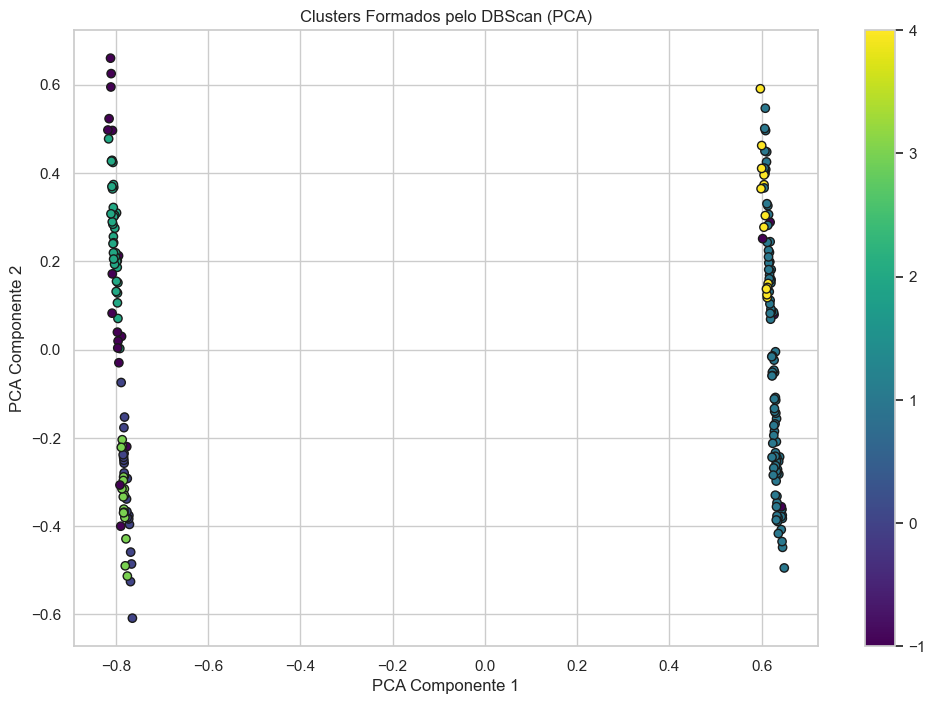


Número de clusters: 5
Número de pontos de ruído (outliers): 22

Resumo dos Clusters:
     Cluster  Número de Pontos  Média Age  Desvio Age  Média Annual Income  \
0  Cluster 0                21   0.122711    0.112208             0.227166   
1  Cluster 1                94   0.375818    0.252656             0.335194   
2  Cluster 2                34   0.666855    0.203611             0.391032   
3  Cluster 3                16   0.299279    0.085184             0.545594   
4  Cluster 4                13   0.494083    0.139163             0.621059   
5   Outliers                22   0.381993    0.297204             0.377794   

   Desvio Annual Income  Média Spending Score  Desvio Spending Score  
0              0.133903              0.640914               0.145594  
1              0.184700              0.562201               0.209307  
2              0.138926              0.363745               0.175904  
3              0.081914              0.838648               0.114553  
4           

In [13]:
# Reimportando bibliotecas após reset do ambiente
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler



# Converter para valores NumPy
X = df_clean.values

# --- 2. Gráfico do Cotovelo para escolher o EPS ---
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Ordenar distâncias
distances = np.sort(distances[:, 4])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Gráfico do Cotovelo para Escolha do eps')
plt.xlabel('Pontos')
plt.ylabel('Distância')
plt.grid(True)
plt.savefig("graficos/Gráfico do Cotovelo para Escolha do eps.png")
plt.show()

# --- 3. Aplicar DBScan ---
eps_value = 0.20  # Ajuste manualmente baseado no gráfico
dbscan = DBSCAN(eps=eps_value, min_samples=5)
clusters = dbscan.fit_predict(X)

# --- 4. Reduzir para 2D com PCA para visualização ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', edgecolor='k')
plt.colorbar(scatter)
plt.title('Clusters Formados pelo DBScan (PCA)')
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.savefig("graficos/Clusters Formados pelo DBScan (PCA).png")
plt.show()

# --- 5. Análise dos Clusters ---
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
print(f'\nNúmero de clusters: {n_clusters}')
print(f'Número de pontos de ruído (outliers): {n_noise}')

# Resumo estatístico dos clusters
cluster_summary = []
for cluster in set(clusters):
    mask = clusters == cluster
    if cluster == -1:
        cluster_name = "Outliers"
    else:
        cluster_name = f"Cluster {cluster}"
    
    cluster_data = X[mask]
    summary = {
        'Cluster': cluster_name,
        'Número de Pontos': len(cluster_data),
        'Média Age': np.mean(cluster_data[:, 0]),
        'Desvio Age': np.std(cluster_data[:, 0]),
        'Média Annual Income': np.mean(cluster_data[:, 1]),
        'Desvio Annual Income': np.std(cluster_data[:, 1]),
        'Média Spending Score': np.mean(cluster_data[:, 2]),
        'Desvio Spending Score': np.std(cluster_data[:, 2]),
    }
    cluster_summary.append(summary)

# Converter para DataFrame
cluster_summary_df = pd.DataFrame(cluster_summary)
print('\nResumo dos Clusters:')
print(cluster_summary_df)

Calculando métricas de validação...


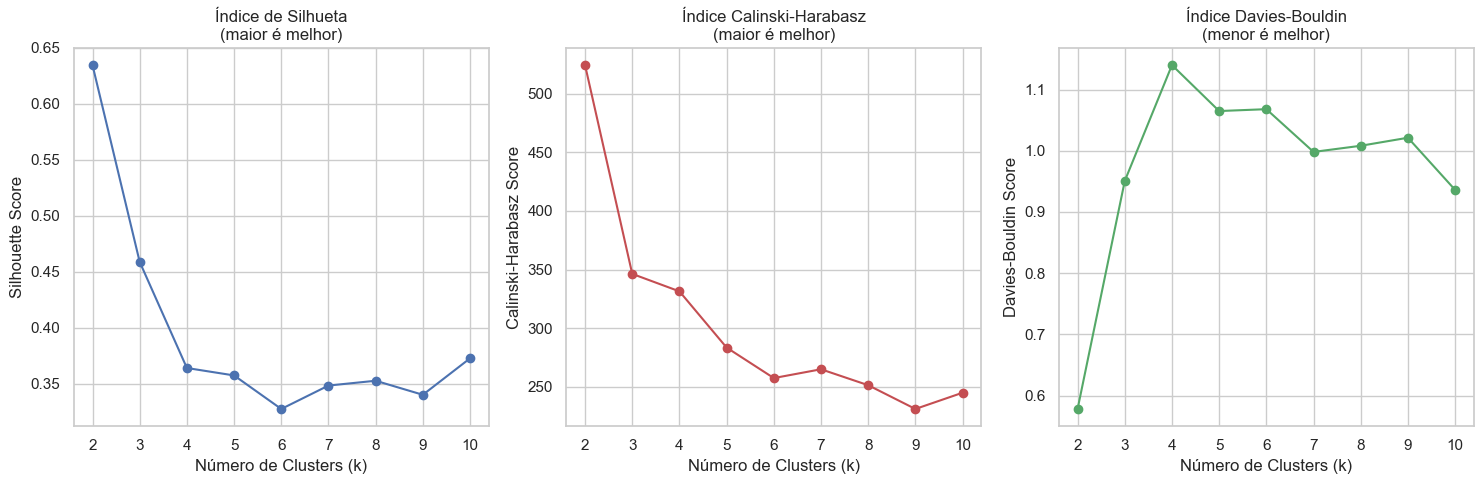


Resultados por métrica:
Melhor k pelo Índice de Silhueta: 2
Score: 0.635

Melhor k pelo Índice Calinski-Harabasz: 2
Score: 524.263

Melhor k pelo Índice Davies-Bouldin: 2
Score: 0.578

Análise detalhada para cada número de clusters:

k = 2
Silhouette Score: 0.635
Calinski-Harabasz Score: 524.263
Davies-Bouldin Score: 0.578

k = 3
Silhouette Score: 0.459
Calinski-Harabasz Score: 346.270
Davies-Bouldin Score: 0.951

k = 4
Silhouette Score: 0.364
Calinski-Harabasz Score: 331.381
Davies-Bouldin Score: 1.140

k = 5
Silhouette Score: 0.358
Calinski-Harabasz Score: 283.449
Davies-Bouldin Score: 1.065

k = 6
Silhouette Score: 0.328
Calinski-Harabasz Score: 257.462
Davies-Bouldin Score: 1.068

k = 7
Silhouette Score: 0.348
Calinski-Harabasz Score: 264.963
Davies-Bouldin Score: 0.998

k = 8
Silhouette Score: 0.353
Calinski-Harabasz Score: 251.380
Davies-Bouldin Score: 1.008

k = 9
Silhouette Score: 0.340
Calinski-Harabasz Score: 231.113
Davies-Bouldin Score: 1.021

k = 10
Silhouette Score: 0.37

In [14]:
## Avaliar diferentes números de clusters para o algoritmo K-Means usando métricas de validação para modelos de clusterização

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

def evaluate_clustering_metrics(df_clean, max_k=10):
    """
    Avalia diferentes números de clusters usando múltiplas métricas
    """
    silhouette_scores = []
    ch_scores = []
    db_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(df_clean)
        
        silhouette_scores.append(silhouette_score(df_clean, labels))
        ch_scores.append(calinski_harabasz_score(df_clean, labels))
        db_scores.append(davies_bouldin_score(df_clean, labels))
    
    return silhouette_scores, ch_scores, db_scores

def plot_validation_metrics(silhouette_scores, ch_scores, db_scores):
    """
    Plota as três métricas de validação
    """
    k_range = range(2, len(silhouette_scores) + 2)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Silhouette Score (maior é melhor)
    ax1.plot(k_range, silhouette_scores, 'bo-')
    ax1.set_xlabel('Número de Clusters (k)')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Índice de Silhueta\n(maior é melhor)')
    ax1.grid(True)
    
    # Calinski-Harabasz Score (maior é melhor)
    ax2.plot(k_range, ch_scores, 'ro-')
    ax2.set_xlabel('Número de Clusters (k)')
    ax2.set_ylabel('Calinski-Harabasz Score')
    ax2.set_title('Índice Calinski-Harabasz\n(maior é melhor)')
    ax2.grid(True)
    
    # Davies-Bouldin Score (menor é melhor)
    ax3.plot(k_range, db_scores, 'go-')
    ax3.set_xlabel('Número de Clusters (k)')
    ax3.set_ylabel('Davies-Bouldin Score')
    ax3.set_title('Índice Davies-Bouldin\n(menor é melhor)')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return k_range

# Calcular métricas
print("Calculando métricas de validação...")
silhouette_scores, ch_scores, db_scores = evaluate_clustering_metrics(df_clean)

# Plotar resultados
k_range = plot_validation_metrics(silhouette_scores, ch_scores, db_scores)

# Encontrar melhores valores para cada métrica
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_ch = k_range[np.argmax(ch_scores)]
best_k_db = k_range[np.argmin(db_scores)]

print("\nResultados por métrica:")
print(f"Melhor k pelo Índice de Silhueta: {best_k_silhouette}")
print(f"Score: {max(silhouette_scores):.3f}")
print(f"\nMelhor k pelo Índice Calinski-Harabasz: {best_k_ch}")
print(f"Score: {max(ch_scores):.3f}")
print(f"\nMelhor k pelo Índice Davies-Bouldin: {best_k_db}")
print(f"Score: {min(db_scores):.3f}")

# Análise detalhada para cada k
print("\nAnálise detalhada para cada número de clusters:")
for k, (sil, ch, db) in enumerate(zip(silhouette_scores, ch_scores, db_scores), 2):
    print(f"\nk = {k}")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Calinski-Harabasz Score: {ch:.3f}")
    print(f"Davies-Bouldin Score: {db:.3f}")


Número de clusters: 2
Davies-Bouldin Index: 0.578
Calinski-Harabasz Index: 524.263

Número de clusters: 3
Davies-Bouldin Index: 0.951
Calinski-Harabasz Index: 346.270

Número de clusters: 4
Davies-Bouldin Index: 1.140
Calinski-Harabasz Index: 331.381

Número de clusters: 5
Davies-Bouldin Index: 1.065
Calinski-Harabasz Index: 283.449

Número de clusters: 6
Davies-Bouldin Index: 1.068
Calinski-Harabasz Index: 257.462

Número de clusters: 7
Davies-Bouldin Index: 0.998
Calinski-Harabasz Index: 264.963

Número de clusters: 8
Davies-Bouldin Index: 1.008
Calinski-Harabasz Index: 251.380

Número de clusters: 9
Davies-Bouldin Index: 1.021
Calinski-Harabasz Index: 231.113

Número de clusters: 10
Davies-Bouldin Index: 0.936
Calinski-Harabasz Index: 244.973


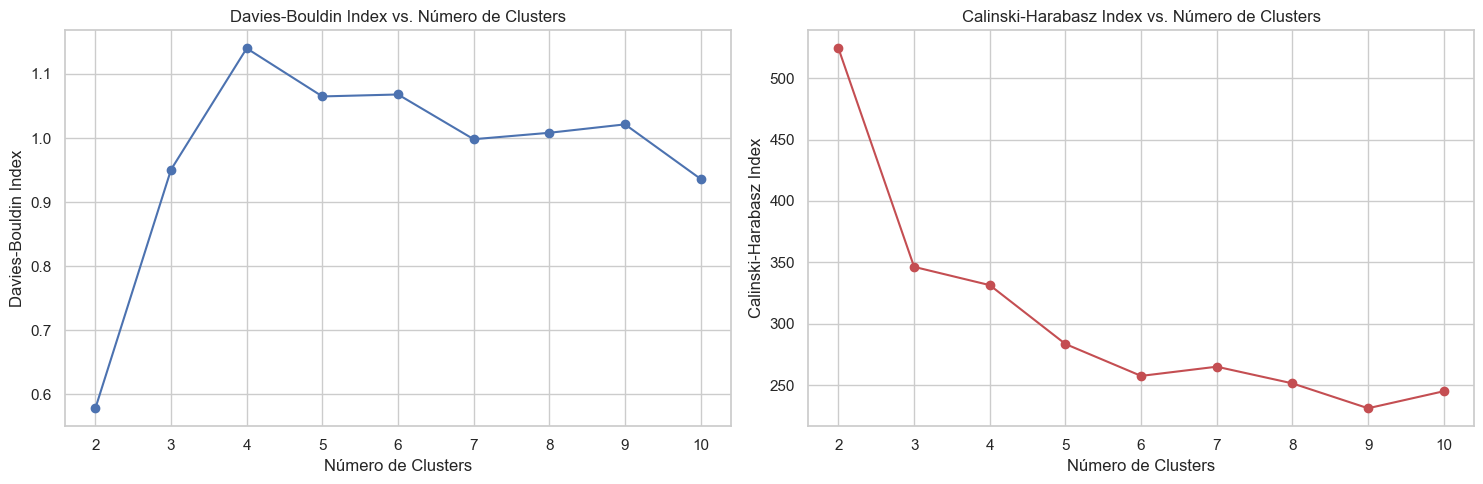


Análise Comparativa das Métricas de Validação:
             Métrica  K-Means (k=2)  Melhor K  Melhor Valor
0     Davies-Bouldin       0.578264         2      0.578264
1  Calinski-Harabasz     524.262736         2    524.262736

Interpretação dos Resultados:
1. Davies-Bouldin Index (DB):
   - Valores menores indicam melhor separação entre clusters
   - Melhor resultado obtido com k = 2

2. Calinski-Harabasz Index (CH):
   - Valores maiores indicam clusters mais densos e bem separados
   - Melhor resultado obtido com k = 2


In [15]:
## Avaliar diferentes números de clusters para o algoritmo K-Means usando métricas de validação para modelos de clusterização

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

def detailed_cluster_validation(X, max_clusters=10):
    """
    Realiza uma análise detalhada das métricas Davies-Bouldin e Calinski-Harabasz.
    """
    db_scores = []
    ch_scores = []
    
    # Calcular métricas para diferentes números de clusters
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        
        db_score = davies_bouldin_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        
        db_scores.append(db_score)
        ch_scores.append(ch_score)
        
        # Imprimir detalhes para cada k
        print(f"\nNúmero de clusters: {k}")
        print(f"Davies-Bouldin Index: {db_score:.3f}")
        print(f"Calinski-Harabasz Index: {ch_score:.3f}")
    
    # Criar visualização
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Davies-Bouldin Index
    ax1.plot(range(2, max_clusters + 1), db_scores, 'bo-')
    ax1.set_xlabel('Número de Clusters')
    ax1.set_ylabel('Davies-Bouldin Index')
    ax1.set_title('Davies-Bouldin Index vs. Número de Clusters')
    ax1.grid(True)
    
    # Calinski-Harabasz Index
    ax2.plot(range(2, max_clusters + 1), ch_scores, 'ro-')
    ax2.set_xlabel('Número de Clusters')
    ax2.set_ylabel('Calinski-Harabasz Index')
    ax2.set_title('Calinski-Harabasz Index vs. Número de Clusters')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Encontrar valores ótimos
    best_db_k = np.argmin(db_scores) + 2
    best_ch_k = np.argmax(ch_scores) + 2
    
    # Criar DataFrame com resultados para k=2 (conforme análise de silhueta)
    kmeans_2 = KMeans(n_clusters=2, random_state=42)
    labels_2 = kmeans_2.fit_predict(y)
    
    db_score_2 = davies_bouldin_score(y, labels_2)
    ch_score_2 = calinski_harabasz_score(y, labels_2)
    
    results = pd.DataFrame({
        'Métrica': ['Davies-Bouldin', 'Calinski-Harabasz'],
        'K-Means (k=2)': [db_score_2, ch_score_2],
        'Melhor K': [best_db_k, best_ch_k],
        'Melhor Valor': [min(db_scores), max(ch_scores)]
    })
    
    return results, db_scores, ch_scores

# Executar análise
y = df_clean.values
results, db_scores, ch_scores = detailed_cluster_validation(y)

print("\nAnálise Comparativa das Métricas de Validação:")
print(results)

print("\nInterpretação dos Resultados:")
print("1. Davies-Bouldin Index (DB):")
print("   - Valores menores indicam melhor separação entre clusters")
print("   - Melhor resultado obtido com k =", results.loc[0, 'Melhor K'])

print("\n2. Calinski-Harabasz Index (CH):")
print("   - Valores maiores indicam clusters mais densos e bem separados")
print("   - Melhor resultado obtido com k =", results.loc[1, 'Melhor K'])

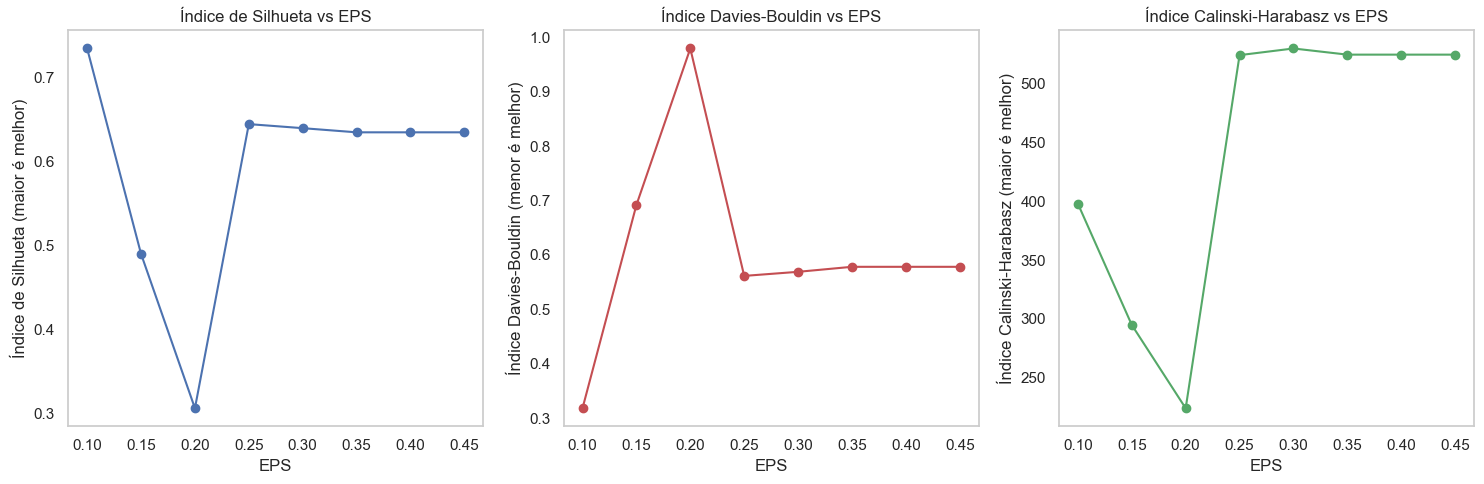


--- Melhor EPS e Índices para Cada Métrica ---
1. Melhor EPS pelo Índice de Silhueta: 0.10 (Valor: 0.735)
   -> A Silhueta indica clusters bem definidos e separados.

2. Melhor EPS pelo Índice Davies-Bouldin: 0.10 (Valor: 0.319)
   -> Davies-Bouldin indica clusters muito compactos e bem separados.

3. Melhor EPS pelo Índice Calinski-Harabasz: 0.30 (Valor: 529.487)
   -> Calinski-Harabasz indica boa densidade e separação entre clusters.

--- Conclusão Final ---
Com base nos três índices, selecione o valor de EPS que equilibra as melhores métricas.


In [16]:
# Importação das bibliotecas necessárias
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

# --- Pré-processamento ---
X = df_clean.values

# --- Definir a faixa de eps para teste ---
eps_values = np.arange(0.1, 0.5, 0.05)  # Valores de eps entre 0.1 e 0.5 com incremento de 0.05
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# --- Loop para calcular as métricas para diferentes eps ---
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    clusters = dbscan.fit_predict(X)

    # Ignorar outliers (-1) ao calcular as métricas
    mask_valid = clusters != -1
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    
    if n_clusters > 1:  # Métricas precisam de pelo menos 2 clusters
        silhouette = silhouette_score(X[mask_valid], clusters[mask_valid])
        davies_bouldin = davies_bouldin_score(X[mask_valid], clusters[mask_valid])
        calinski_harabasz = calinski_harabasz_score(X[mask_valid], clusters[mask_valid])
    else:
        silhouette = -1
        davies_bouldin = np.nan
        calinski_harabasz = np.nan

    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)

# --- Identificar o melhor valor de eps para cada métrica ---
best_eps_silhouette = eps_values[np.argmax(silhouette_scores)]
best_silhouette_value = max(silhouette_scores)

best_eps_davies = eps_values[np.nanargmin(davies_bouldin_scores)]
best_davies_value = np.nanmin(davies_bouldin_scores)

best_eps_calinski = eps_values[np.nanargmax(calinski_harabasz_scores)]
best_calinski_value = np.nanmax(calinski_harabasz_scores)

# --- Plotar os gráficos das métricas ---
plt.figure(figsize=(15, 5))

# Gráfico do Índice de Silhueta
plt.subplot(1, 3, 1)
plt.plot(eps_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Índice de Silhueta vs EPS')
plt.xlabel('EPS')
plt.ylabel('Índice de Silhueta (maior é melhor)')
plt.grid()

# Gráfico do Índice Davies-Bouldin
plt.subplot(1, 3, 2)
plt.plot(eps_values, davies_bouldin_scores, marker='o', linestyle='-', color='r')
plt.title('Índice Davies-Bouldin vs EPS')
plt.xlabel('EPS')
plt.ylabel('Índice Davies-Bouldin (menor é melhor)')
plt.grid()

# Gráfico do Índice Calinski-Harabasz
plt.subplot(1, 3, 3)
plt.plot(eps_values, calinski_harabasz_scores, marker='o', linestyle='-', color='g')
plt.title('Índice Calinski-Harabasz vs EPS')
plt.xlabel('EPS')
plt.ylabel('Índice Calinski-Harabasz (maior é melhor)')
plt.grid()

plt.tight_layout()
plt.savefig("graficos/Métricas_de_Validação_DBSCAN.png")
plt.show()

# --- Exibir os melhores valores de eps e suas métricas ---
print("\n--- Melhor EPS e Índices para Cada Métrica ---")
print(f"1. Melhor EPS pelo Índice de Silhueta: {best_eps_silhouette:.2f} (Valor: {best_silhouette_value:.3f})")
if best_silhouette_value > 0.5:
    print("   -> A Silhueta indica clusters bem definidos e separados.")
elif 0.3 < best_silhouette_value <= 0.5:
    print("   -> A Silhueta indica clusters moderadamente definidos.")
else:
    print("   -> A Silhueta sugere baixa qualidade na separação dos clusters.")

print(f"\n2. Melhor EPS pelo Índice Davies-Bouldin: {best_eps_davies:.2f} (Valor: {best_davies_value:.3f})")
if best_davies_value < 0.5:
    print("   -> Davies-Bouldin indica clusters muito compactos e bem separados.")
elif 0.5 <= best_davies_value <= 1.0:
    print("   -> Davies-Bouldin indica clusters razoavelmente compactos.")
else:
    print("   -> Davies-Bouldin sugere que os clusters estão menos compactos.")

print(f"\n3. Melhor EPS pelo Índice Calinski-Harabasz: {best_eps_calinski:.2f} (Valor: {best_calinski_value:.3f})")
if best_calinski_value > 200:
    print("   -> Calinski-Harabasz indica boa densidade e separação entre clusters.")
else:
    print("   -> Calinski-Harabasz sugere clusters menos bem definidos.")

# --- Conclusão Final ---
print("\n--- Conclusão Final ---")
print("Com base nos três índices, selecione o valor de EPS que equilibra as melhores métricas.")


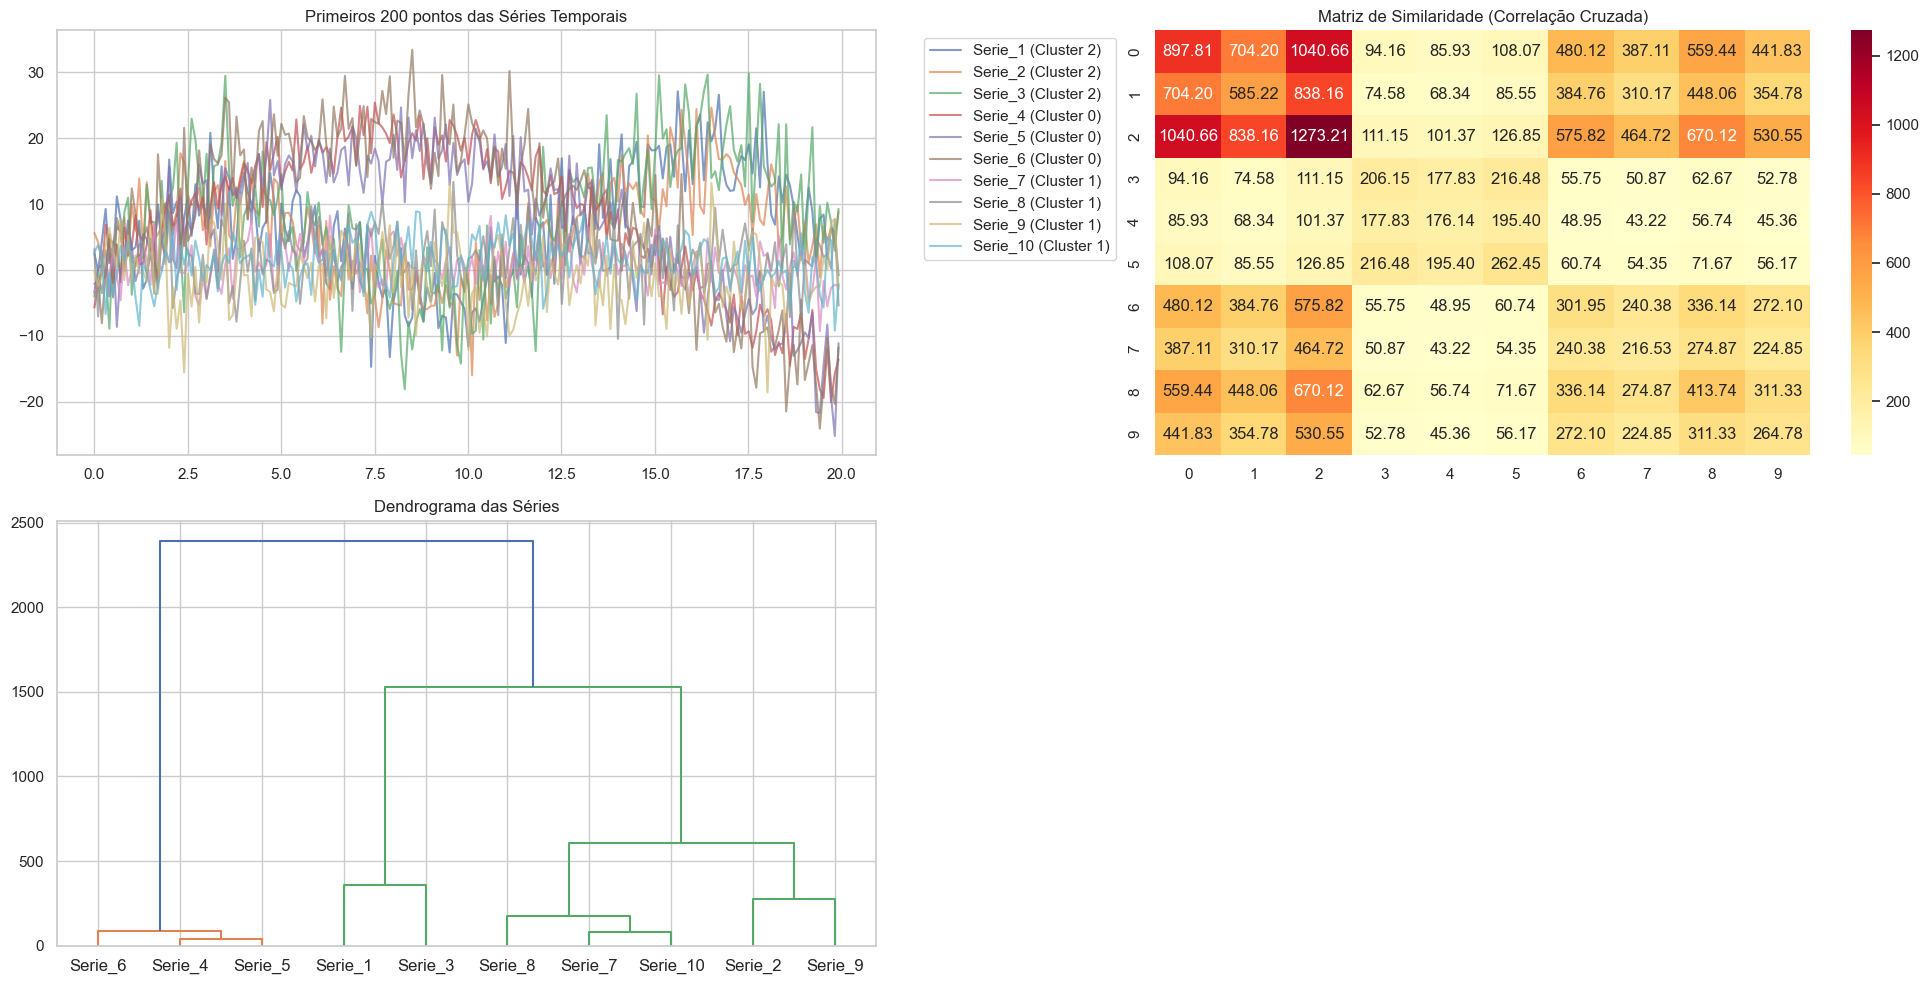


Resultados da Clusterização:
Série 1 pertence ao cluster 2
Série 2 pertence ao cluster 2
Série 3 pertence ao cluster 2
Série 4 pertence ao cluster 0
Série 5 pertence ao cluster 0
Série 6 pertence ao cluster 0
Série 7 pertence ao cluster 1
Série 8 pertence ao cluster 1
Série 9 pertence ao cluster 1
Série 10 pertence ao cluster 1

Similaridade média dentro dos clusters:
Cluster 0: 196.570
Cluster 1: 276.613
Cluster 2: 861.005


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# Criar dados sintéticos - 10 séries temporais
np.random.seed(42)
t = np.linspace(0, 100, 1000)

# Grupo 1: Séries com tendência crescente e sazonalidade similar
series_1 = 0.5 * t + 10 * np.sin(0.5 * t) + np.random.normal(0, 5, 1000)
series_2 = 0.4 * t + 9 * np.sin(0.5 * t) + np.random.normal(0, 4, 1000)
series_3 = 0.6 * t + 11 * np.sin(0.5 * t) + np.random.normal(0, 6, 1000)

# Grupo 2: Séries com padrão cíclico
series_4 = 20 * np.sin(0.2 * t) + np.random.normal(0, 3, 1000)
series_5 = 18 * np.sin(0.2 * t) + np.random.normal(0, 4, 1000)
series_6 = 22 * np.sin(0.2 * t) + np.random.normal(0, 5, 1000)

# Grupo 3: Séries com tendência decrescente
series_7 = -0.3 * t + 5 * np.sin(0.1 * t) + np.random.normal(0, 3, 1000)
series_8 = -0.25 * t + 6 * np.sin(0.1 * t) + np.random.normal(0, 4, 1000)
series_9 = -0.35 * t + 4 * np.sin(0.1 * t) + np.random.normal(0, 5, 1000)
series_10 = -0.28 * t + 5.5 * np.sin(0.1 * t) + np.random.normal(0, 3.5, 1000)

# Criar DataFrame
series_dict = {
    'Serie_1': series_1,
    'Serie_2': series_2,
    'Serie_3': series_3,
    'Serie_4': series_4,
    'Serie_5': series_5,
    'Serie_6': series_6,
    'Serie_7': series_7,
    'Serie_8': series_8,
    'Serie_9': series_9,
    'Serie_10': series_10
}
df = pd.DataFrame(series_dict)

def calc_max_cross_correlation(x, y):
    """Calcula a máxima correlação cruzada entre duas séries"""
    correlation = signal.correlate(x, y, mode='full')
    max_corr = np.max(np.abs(correlation)) / len(x)
    return max_corr

# Calcular matriz de similaridade
n_series = len(df.columns)
similarity_matrix = np.zeros((n_series, n_series))

for i in range(n_series):
    for j in range(n_series):
        similarity_matrix[i,j] = calc_max_cross_correlation(
            df.iloc[:,i], 
            df.iloc[:,j]
        )

# Converter similaridade para distância
distance_matrix = 1 - similarity_matrix

# Aplicar KMeans na matriz de distância
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(distance_matrix)

# Visualizações
plt.figure(figsize=(20, 10))

# Plot 1: Séries Temporais com Cores por Cluster
plt.subplot(2, 2, 1)
for i, col in enumerate(df.columns):
    plt.plot(t[:200], df[col][:200], label=f'{col} (Cluster {clusters[i]})', 
             alpha=0.7)
plt.title('Primeiros 200 pontos das Séries Temporais')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Matriz de Similaridade
plt.subplot(2, 2, 2)
sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Matriz de Similaridade (Correlação Cruzada)')

# Plot 3: Dendrograma usando a matriz de distância
from scipy.cluster.hierarchy import dendrogram, linkage
plt.subplot(2, 2, 3)
linkage_matrix = linkage(distance_matrix, method='ward')
dendrogram(linkage_matrix, labels=df.columns)
plt.title('Dendrograma das Séries')

plt.tight_layout()
plt.show()

# Imprimir resultados
print("\nResultados da Clusterização:")
for i in range(n_series):
    print(f"Série {i+1} pertence ao cluster {clusters[i]}")

# Calcular similaridade média dentro dos clusters
print("\nSimilaridade média dentro dos clusters:")
for cluster in range(3):
    mask = clusters == cluster
    cluster_series = np.where(mask)[0]
    
    if len(cluster_series) > 1:
        similarities = []
        for i in range(len(cluster_series)):
            for j in range(i+1, len(cluster_series)):
                similarities.append(similarity_matrix[cluster_series[i], cluster_series[j]])
        print(f"Cluster {cluster}: {np.mean(similarities):.3f}")

Calculando matriz de distância DTW...
Aplicando clustering...
Gerando visualizações...


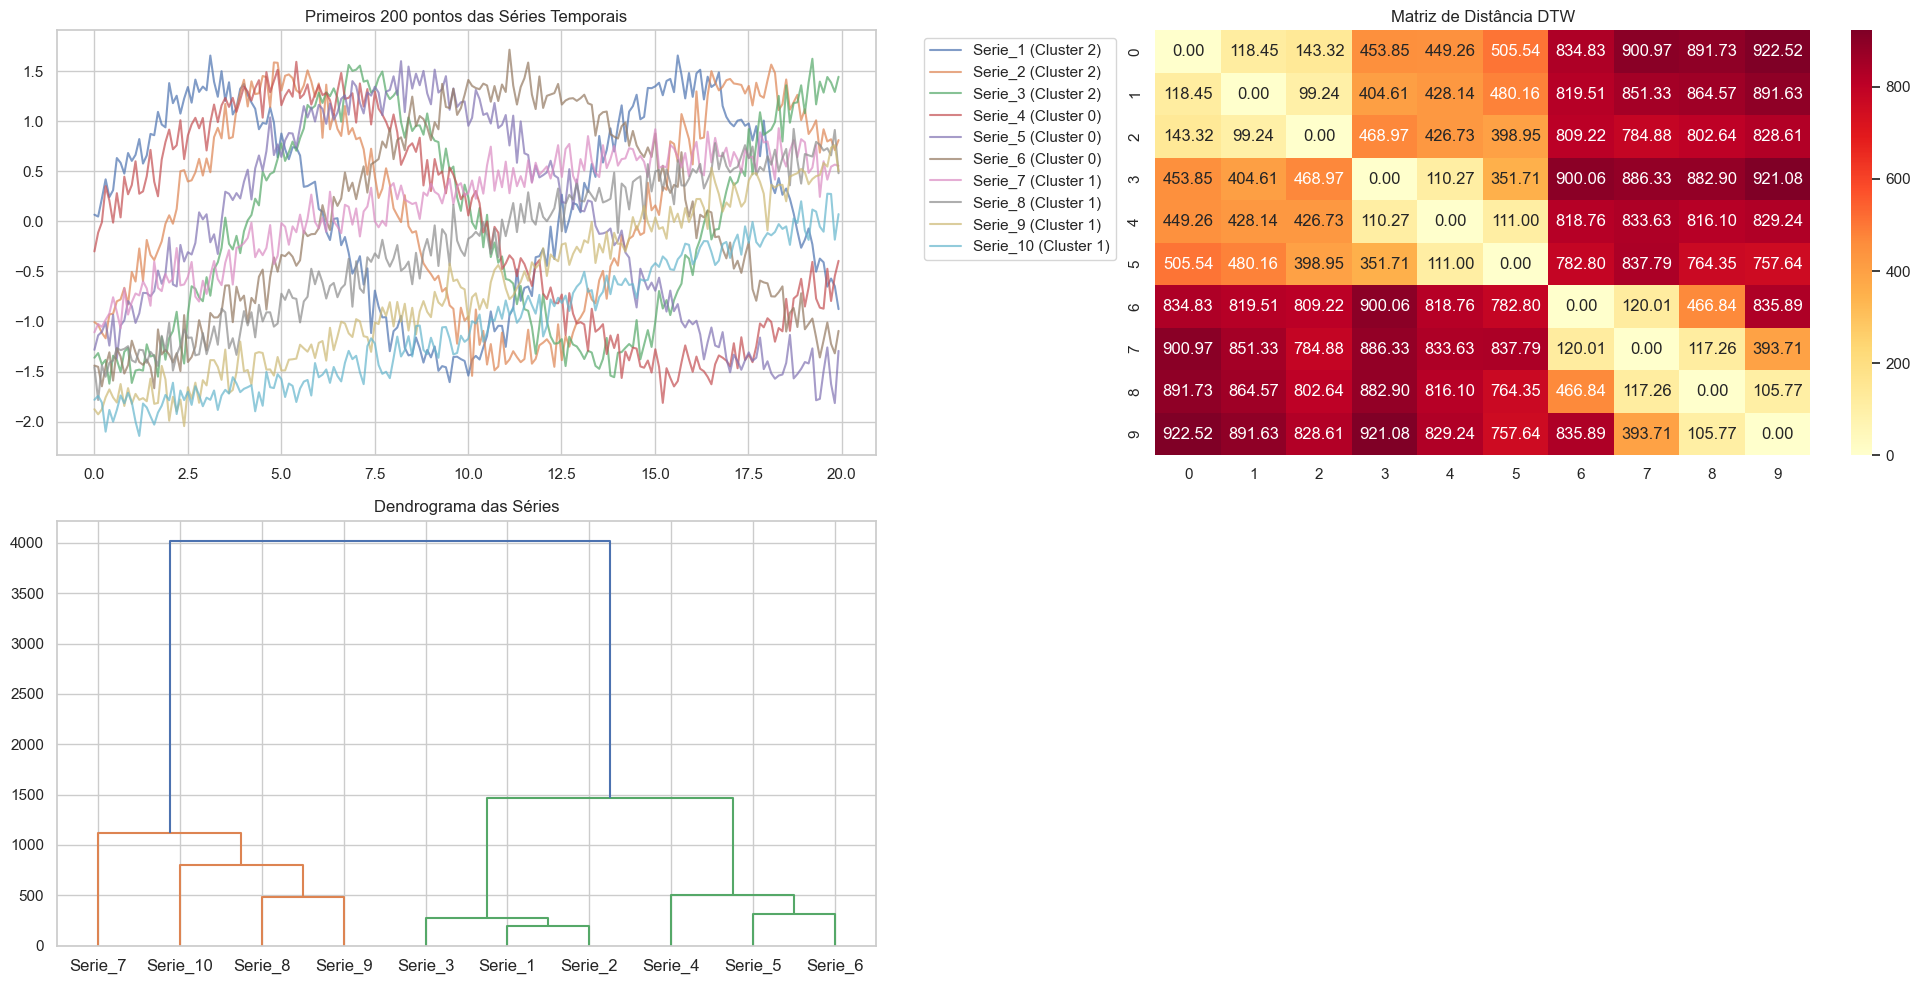


Resultados da Clusterização:
Série 1 pertence ao cluster 2
Série 2 pertence ao cluster 2
Série 3 pertence ao cluster 2
Série 4 pertence ao cluster 0
Série 5 pertence ao cluster 0
Série 6 pertence ao cluster 0
Série 7 pertence ao cluster 1
Série 8 pertence ao cluster 1
Série 9 pertence ao cluster 1
Série 10 pertence ao cluster 1

Distância média dentro dos clusters:
Cluster 0: 190.992
Cluster 1: 339.911
Cluster 2: 120.339


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

def generate_sample_series():
    """Gera séries temporais sintéticas com padrões diferentes"""
    np.random.seed(42)
    t = np.linspace(0, 100, 1000)
    
    # Grupo 1: Séries com padrão similar mas com defasagem
    series_1 = np.sin(0.5 * t) + np.random.normal(0, 0.1, 1000)
    series_2 = np.sin(0.5 * (t - 2)) + np.random.normal(0, 0.1, 1000)
    series_3 = np.sin(0.5 * (t - 4)) + np.random.normal(0, 0.1, 1000)
    
    # Grupo 2: Séries com frequência diferente
    series_4 = np.sin(0.3 * t) + np.random.normal(0, 0.1, 1000)
    series_5 = np.sin(0.3 * (t - 3)) + np.random.normal(0, 0.1, 1000)
    series_6 = np.sin(0.3 * (t - 6)) + np.random.normal(0, 0.1, 1000)
    
    # Grupo 3: Séries com tendência
    series_7 = 0.01 * t + np.sin(0.1 * t) + np.random.normal(0, 0.1, 1000)
    series_8 = 0.01 * t + np.sin(0.1 * (t - 5)) + np.random.normal(0, 0.1, 1000)
    series_9 = 0.01 * t + np.sin(0.1 * (t - 10)) + np.random.normal(0, 0.1, 1000)
    series_10 = 0.01 * t + np.sin(0.1 * (t - 15)) + np.random.normal(0, 0.1, 1000)
    
    series_dict = {
        'Serie_1': series_1, 'Serie_2': series_2, 'Serie_3': series_3,
        'Serie_4': series_4, 'Serie_5': series_5, 'Serie_6': series_6,
        'Serie_7': series_7, 'Serie_8': series_8, 'Serie_9': series_9,
        'Serie_10': series_10
    }
    return pd.DataFrame(series_dict), t

def dtw_distance(serie1, serie2, window=None):
    """Calcula a distância DTW entre duas séries temporais"""
    n, m = len(serie1), len(serie2)
    
    # Criar matriz de custo
    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0, 0] = 0
    
    # Definir janela de restrição (se especificada)
    if window is None:
        window = max(n, m)
    
    # Preencher matriz DTW
    for i in range(1, n+1):
        for j in range(max(1, i-window), min(m+1, i+window+1)):
            cost = abs(serie1[i-1] - serie2[j-1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i-1, j],    # inserção
                dtw_matrix[i, j-1],    # deleção
                dtw_matrix[i-1, j-1]   # correspondência
            )
    
    return dtw_matrix[n, m]

def create_distance_matrix(df, window=None):
    """Cria matriz de distância DTW para todas as séries"""
    n_series = len(df.columns)
    distance_matrix = np.zeros((n_series, n_series))
    
    for i in range(n_series):
        for j in range(i+1, n_series):
            dist = dtw_distance(df.iloc[:, i], df.iloc[:, j], window)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    
    return distance_matrix

def plot_results(df, t, distance_matrix, clusters, n_points=200):
    """Cria visualizações dos resultados"""
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Séries Temporais com Cores por Cluster
    plt.subplot(2, 2, 1)
    for i, col in enumerate(df.columns):
        plt.plot(t[:n_points], df[col][:n_points], 
                label=f'{col} (Cluster {clusters[i]})', 
                alpha=0.7)
    plt.title('Primeiros 200 pontos das Séries Temporais')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: Matriz de Distância DTW
    plt.subplot(2, 2, 2)
    sns.heatmap(distance_matrix, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Matriz de Distância DTW')
    
    # Plot 3: Dendrograma
    plt.subplot(2, 2, 3)
    linkage_matrix = linkage(distance_matrix, method='ward')
    dendrogram(linkage_matrix, labels=df.columns)
    plt.title('Dendrograma das Séries')
    
    plt.tight_layout()
    plt.show()

def analyze_clusters(df, distance_matrix, clusters):
    """Analisa a qualidade dos clusters"""
    print("\nResultados da Clusterização:")
    for i in range(len(df.columns)):
        print(f"Série {i+1} pertence ao cluster {clusters[i]}")
    
    print("\nDistância média dentro dos clusters:")
    for cluster in range(3):
        mask = clusters == cluster
        cluster_series = np.where(mask)[0]
        
        if len(cluster_series) > 1:
            distances = []
            for i in range(len(cluster_series)):
                for j in range(i+1, len(cluster_series)):
                    distances.append(distance_matrix[cluster_series[i], 
                                                  cluster_series[j]])
            print(f"Cluster {cluster}: {np.mean(distances):.3f}")

# Principal
def main():
    # Gerar dados de exemplo
    df, t = generate_sample_series()
    
    # Normalizar os dados
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df),
        columns=df.columns
    )
    
    # Calcular matriz de distância DTW
    print("Calculando matriz de distância DTW...")
    distance_matrix = create_distance_matrix(df_scaled, window=50)
    
    # Aplicar clustering
    print("Aplicando clustering...")
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(distance_matrix)
    
    # Visualizar resultados
    print("Gerando visualizações...")
    plot_results(df_scaled, t, distance_matrix, clusters)
    
    # Analisar clusters
    analyze_clusters(df_scaled, distance_matrix, clusters)

if __name__ == "__main__":
    main()